# Practical on the use of clustering

# Part 2: Partition-based clustering
In this part of the practical, you will apply partition-based clustering (specifically, algorithm <b>K-Means</b>) to aggregated data consisting of weekly counts of individual photo-taking events in 5 regions in the North America. The regions are labelled as NE (North-East), SE (South-East), NW (North-West), SW (South-West), and GL (Great Lakes).

<pre>conda install -c conda-forge cufflinks-py</pre>


In [1]:
# Importing Libraries
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9.0, 3.0)

#import seaborn as sns
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
#pd.options.display.max_columns = 30
#from IPython.core.interactiveshell import InteractiveShell
#import chart_studio.plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(123)


### A function for generating colours according to positions in a 2D projection
The following function <b><i>getColor(...)</i></b> will be used for a meaningful assignment of colours to clusters. 
The idea is to represent clusters by points in an artificial 2D space by applying a data embedding method 
(such as MDS - non-linear multidimensional scaling) to aggregate characteristics of clusters and generate colours for the clusters based on the positions of the corresponding points.

In [2]:
import math
def getColor (x, y, minX, maxX, minY, maxY):
    wX=maxX-minX 
    wY=maxY-minY
    rr=y-minY 
    cc=x-minX
    #print(x,y)
    if (wY < wX):   #scale vertically, i.e. modify rr
        rr *= wX/wY  
    else:           #scale horizontally, i.e. modify cc
        cc *= wY/wX
    maxD=max(wX,wY)
    rr1=maxD-rr
    cc1=maxD-cc
    #print(rr,cc,maxD,rr1,cc1)
    dc=[math.sqrt(rr*rr+cc*cc),math.sqrt(rr*rr+cc1*cc1),math.sqrt(rr1*rr1+cc*cc),math.sqrt(rr1*rr1+cc1*cc1)]
    weights=[0.0,0.0,0.0,0.0]
    for i in range(len(weights)):
        weights[i]=(maxD-dc[i])/maxD
        if (weights[i]<0):
            weights[i]=0
    #print(dc,weights)
    reds=[228,25,255,37]
    greens=[220,228,18,13]
    blues=[0,218,6,252]
    dr=0
    dg=0
    db=0
    for i,weight in enumerate(weights):
        dr += weight*reds[i]
        dg += weight*greens[i]
        db += weight*blues[i]
    if (dr<0):
        dr=0;
    if (dr>255):
        dr=255
    if (dg<0):
        dg=0;
    if (dg>255):
        dg=255        
    if (db<0):
        db=0;
    if (db>255):
        db=255  
    #print(weights,dr,dg,db)
    c_string = '#{:02x}{:02x}{:02x}'.format(int(dr),int(dg),int(db))    
    return c_string


### Load the data
The data are weekly counts of photo taking events by 5 regions denoted NW, SW, NE, SE, GL.

In [3]:
# Loading csv file into Pandas DataFrame
wd = pd.read_csv('weekly_counts_by_regions.csv')
wd.head(5)

,id,Name,date,year,week of year,NW,SW,NE,GL,SE
0,01/01/2007,01/01/2007,01/01/2007,2007,1,0,0,1,0,1
1,08/01/2007,08/01/2007,08/01/2007,2007,2,0,0,1,0,1
2,15/01/2007,15/01/2007,15/01/2007,2007,3,0,0,0,0,0
3,22/01/2007,22/01/2007,22/01/2007,2007,4,2,0,0,0,1
4,29/01/2007,29/01/2007,29/01/2007,2007,5,0,1,1,1,0


In [4]:
wd.index=wd['id']
wd.head(5)

,id,Name,date,year,week of year,NW,SW,NE,GL,SE
id,,,,,,,,,,
01/01/2007,01/01/2007,01/01/2007,01/01/2007,2007,1,0,0,1,0,1
08/01/2007,08/01/2007,08/01/2007,08/01/2007,2007,2,0,0,1,0,1
15/01/2007,15/01/2007,15/01/2007,15/01/2007,2007,3,0,0,0,0,0
22/01/2007,22/01/2007,22/01/2007,22/01/2007,2007,4,2,0,0,0,1
29/01/2007,29/01/2007,29/01/2007,29/01/2007,2007,5,0,1,1,1,0


## Run the clustering algorithm
The clustering algorithm <b>K-Means</b> has one parameter <b><i>K</i></b>, which is the number of clusters to produce. You are supposed to experiment with different values of this parameter.

To explore how the method works, we recommend this tutorial: https://k-means-explorable.vercel.app/

In [5]:
counts_columns=['NW','SW','NE','SE','GL']
wd_counts=wd.loc[:,counts_columns]

scaler = MinMaxScaler()
wd_counts_scaled=scaler.fit_transform(wd_counts)

K = 6 # Change this value to experiment with different numbers of clusters
kmeans_wd = KMeans(n_clusters=K, random_state=10)

# Fitting the algorithm to the data
kmeans_wd = kmeans_wd.fit(wd_counts_scaled)

# Getting the Cluster labels for the dataframe
labels = kmeans_wd.predict(wd_counts_scaled)

clust_id_col_name='Cluster id'
wd[clust_id_col_name]=labels

# Gettinc cluster sizes
cluster_sizes = wd['Cluster id'].value_counts().rename_axis('Cluster id').to_frame('counts')
print("Cluster sizes:")
print(cluster_sizes)

max_cluster_size=cluster_sizes['counts'].max()
print("max = ",max_cluster_size)

# Getting the Centroid values
centroids = kmeans_wd.cluster_centers_

print("\nCluster centroids:")
print(centroids)


c:\Users\Chris Henry\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster sizes:
            counts
Cluster id        
0              418
4               66
1               13
2               12
3                7
5                5
max =  418

Cluster centroids:
[[0.00599461 0.01257514 0.00496933 0.00877193 0.01435407]
 [0.48541114 0.33925049 0.43959732 0.15384615 0.0361991 ]
 [0.19731801 0.22649573 0.37080537 0.56018519 0.04901961]
 [0.11330049 0.12454212 0.08628955 0.00793651 0.767507  ]
 [0.14437478 0.18026418 0.05531828 0.04713805 0.01871658]
 [0.26896552 0.93333333 0.16040268 0.06666667 0.18431373]]


c:\Users\Chris Henry\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



### Generate colours for the clusters by means of spatialisation
The spatialisation (projection) is applied to the cluster centroids.

c:\Users\Chris Henry\miniconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.

c:\Users\Chris Henry\miniconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



-0.44693137820633894 0.3903311614220023 -0.6683348777017797 0.6627112473499028


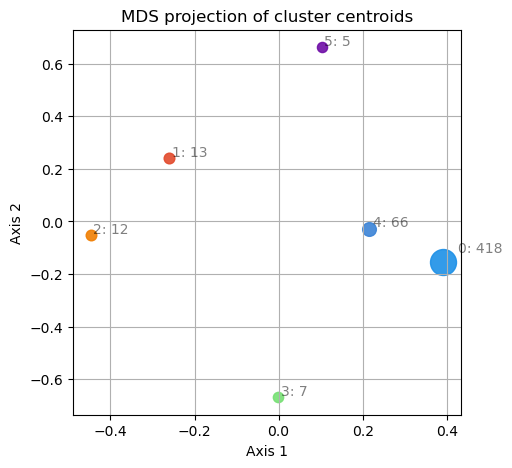

In [6]:
mds_clusters = MDS(n_components = 2, random_state=9)
mds_clusters.fit(centroids)
xy_mds = mds_clusters.fit_transform(centroids)

xmin=xy_mds[:,0].min() 
xmax=xy_mds[:,0].max()
ymin=xy_mds[:,1].min()
ymax=xy_mds[:,1].max()
print(xmin,xmax,ymin,ymax)

plt.figure(figsize=(5,5))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('MDS projection of cluster centroids')
cluster_colors = []

for i in range(len(xy_mds)):
    color=getColor(xy_mds[i,0], xy_mds[i,1],xmin,xmax,ymin,ymax)
    cluster_colors.append(color)
    j=np.where(cluster_sizes.index==i)[0][0]
    r=cluster_sizes.iat[j,0]/max_cluster_size
    size=50 + 300*r
    plt.scatter(xy_mds[i,0], xy_mds[i,1], alpha = .9, c = color, s = size)
    plt.text(xy_mds[i,0]+0.0001*size, xy_mds[i,1]+0.0001*size, str(i)+": "+str(cluster_sizes.iat[j,0]), alpha = .5)

plt.grid()   

### Attach the cluster colours to the data records

In [7]:
data_colors=[]
for id,row in wd.iterrows():
    cluster_id = row[clust_id_col_name]
    data_colors.append(cluster_colors[cluster_id])

wd['Color']=data_colors
wd.head(10)


,id,Name,date,year,week of year,NW,SW,NE,GL,SE,Cluster id,Color
id,,,,,,,,,,,,
01/01/2007,01/01/2007,01/01/2007,01/01/2007,2007,1,0,0,1,0,1,0,#1d90e7
08/01/2007,08/01/2007,08/01/2007,08/01/2007,2007,2,0,0,1,0,1,0,#1d90e7
15/01/2007,15/01/2007,15/01/2007,15/01/2007,2007,3,0,0,0,0,0,0,#1d90e7
22/01/2007,22/01/2007,22/01/2007,22/01/2007,2007,4,2,0,0,0,1,0,#1d90e7
29/01/2007,29/01/2007,29/01/2007,29/01/2007,2007,5,0,1,1,1,0,0,#1d90e7
05/02/2007,05/02/2007,05/02/2007,05/02/2007,2007,6,0,2,0,1,0,0,#1d90e7
12/02/2007,12/02/2007,12/02/2007,12/02/2007,2007,7,0,6,0,0,0,0,#1d90e7
19/02/2007,19/02/2007,19/02/2007,19/02/2007,2007,8,0,8,0,0,0,4,#3b83d6
26/02/2007,26/02/2007,26/02/2007,26/02/2007,2007,9,2,3,1,0,0,0,#1d90e7


### Visualise the temporal distribution of the cluster membership
To account for the cyclic organisation of the time in our data, we create a 2D plot where one dimension corresponds to the yearly cycle (week of a year) and the other dimension to the sequence of the years. Each weekly interval is represented by a mark painted in the colour of the cluster this interval belongs to.

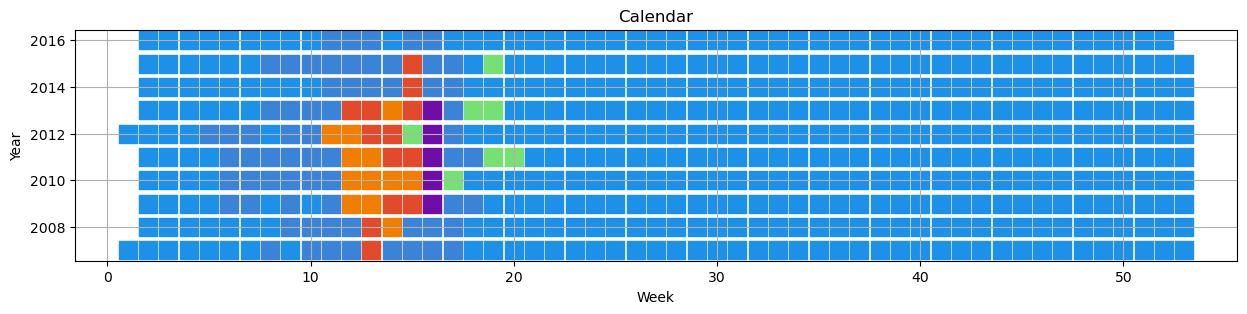

In [8]:
plt.figure(figsize=(15,3))
plt.xlabel('Week')
plt.ylabel('Year')
plt.title('Calendar')
colors = [(0,0,0)]

for id,row in wd.iterrows():
    plt.scatter(row['week of year'],row['year'],alpha = 1, s=150, marker='s',c=row['Color'])

plt.grid()
    
plt.show()    


## Task: observe and characterise patterns in the temporal distribution

### Visualise summary characteristics of the clusters in terms of the region-wise event counts

In [9]:
for i in range(len(counts_columns)):
    boxes=[]
    for j in range(len(centroids)):
        box = go.Box(
            y=wd.loc[wd[clust_id_col_name] == j][counts_columns[i]],
            name = j,
            marker = dict(
                color = cluster_colors[j],
            )
        )
        boxes.append(box)

    layout = go.Layout(
        title = "Statistics of counts by the clusters for region "+counts_columns[i]
    )

    fig = go.Figure(data=boxes,layout=layout)
    iplot(fig, filename = "Statistics of counts by the clusters for region "+counts_columns[i])


## Task 1: Interpret the clusters in terms of the regions having high amounts of photo taking activities.
## Task 2: Compare the times of the highest photo taking activities in the different regions across the years.
For the second task, you need to combine information obtained from the statistical displays with the calendar representation of the temporal distribution cluster membership. 